# Advent of Code - Day 13: A Maze of Twisty Little Cubicles

**Problem by Advent of Code, solution by andreas.roessland@gmail.com**

You arrive at the first floor of this new building to discover a much less welcoming environment than the shiny atrium of the last one. Instead, you are in a maze of twisty little cubicles, all alike.

Every location in this area is addressed by a pair of non-negative integers (x,y). Each such coordinate is either a wall or an open space. You can't move diagonally. The cube maze starts at 0,0 and seems to extend infinitely toward **positive** x and y; negative values are **invalid**, as they represent a location outside the building. You are in a small waiting area at 1,1.

While it seems chaotic, a nearby morale-boosting poster explains, the layout is actually quite logical. You can determine whether a given x,y coordinate will be a wall or an open space using a simple system:

- Find $x^2 + 3x + 2xy + y + y^2$
- Add the office designer's favorite number (your puzzle input).
- Find the binary representation of that sum; count the **number** of bits that are 1.
    - If the number of bits that are 1 is **even**, it's an **open space**.
    - If the number of bits that are 1 is **odd**, it's a **wall**.

For example, if the office designer's favorite number were 10, drawing walls as # and open spaces as ., the corner of the building containing 0,0 would look like this:

      0123456789
    0 .#.####.##
    1 ..#..#...#
    2 #....##...
    3 ###.#.###.
    4 .##..#..#.
    5 ..##....#.
    6 #...##.###

Now, suppose you wanted to reach 7,4. The shortest route you could take is marked as O:

      0123456789
    0 .#.####.##
    1 .O#..#...#
    2 #OOO.##...
    3 ###O#.###.
    4 .##OO#OO#.
    5 ..##OOO.#.
    6 #...##.###

Thus, reaching 7,4 would take a minimum of 11 steps (starting from your current location, 1,1).

What is the **fewest number of steps required** for you to reach 31,39?

Your puzzle input is 1362.

## Draw the building layout

Also add a wall around the boundary. This will make the logic around the borders much easier, but we will have to increment the numbers given in the problem by one.

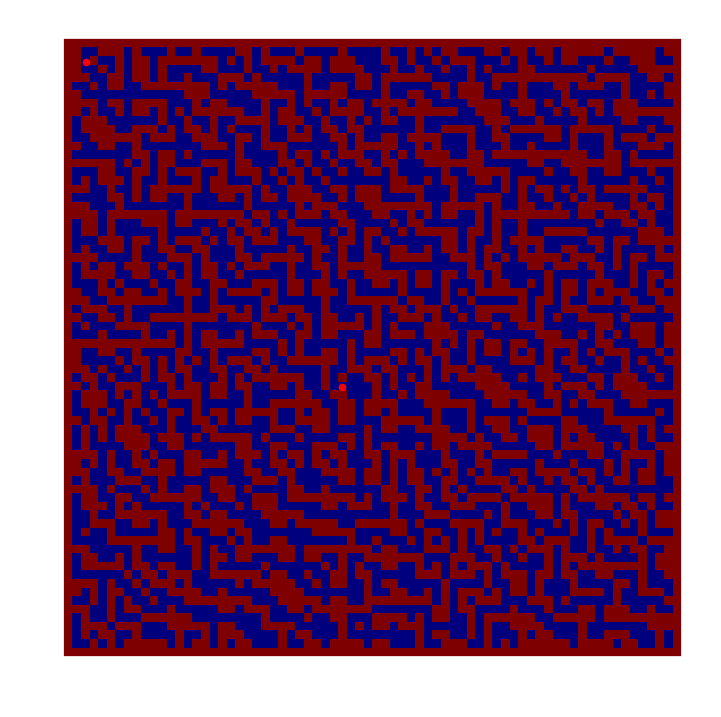

In [311]:
import numpy as np
import matplotlib.pyplot as plt

# Vectorizing allows us to operate on NumPy arrays
is_wall = np.vectorize(lambda y, x: bin(x*x + 3*x +2*x*y + y + y*y + 1362).count("1") % 2 == 1)

max_pos = 70
Y, X = np.mgrid[0:max_pos, 0:max_pos]
wall = np.ones((max_pos+2, max_pos+2), dtype=bool)
wall[1:-1, 1:-1] = is_wall(Y, X)
plt.figure(figsize=(700/80, 700/80))
plt.imshow(wall, interpolation="nearest")
plt.scatter((1+1, 1+31,), (1+1, 1+39,), color="red")
plt.axis("off")
plt.show()

## Build a graph
To find the shortest path to the red dot we will use SciPy's Compressed Sparse Graph Routines. These require that we create a sparse matrix representing the maze graph. The figure below shows the sparsity structure of the constructed graph.

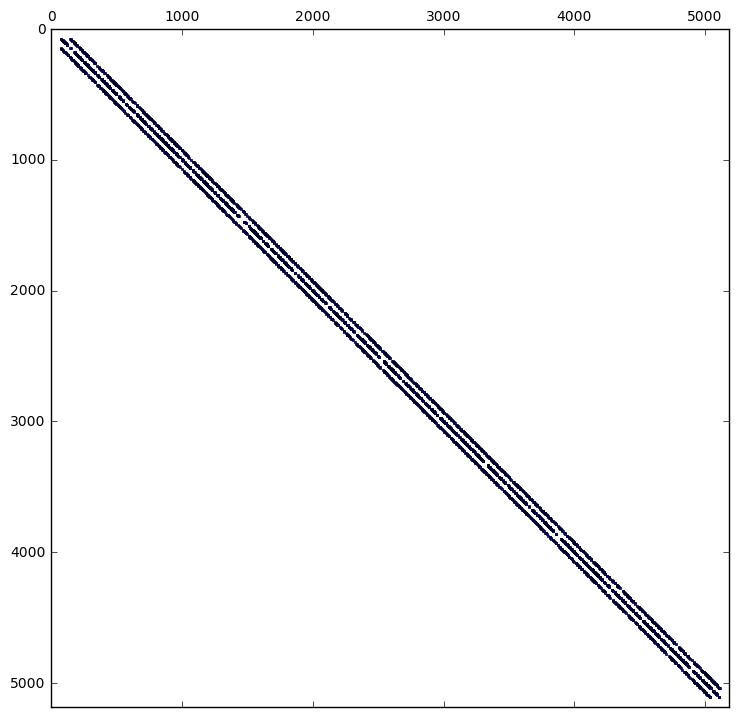

In [312]:
from scipy.sparse import lil_matrix

# Map from coordinate to index in graph matrix
def getnode(y, x):
    return wall.shape[1]*y + x

# Map from index in graph matrix to coordinate
def getpos(node):
    return divmod(node, wall.shape[1])

graph = lil_matrix(((max_pos+2)**2, (max_pos+2)**2))
for x in range(1, max_pos+1):
    for y in range(1, max_pos+1):
        if wall[y,x]:
            continue
        if not wall[y+1,x]:
            graph[getnode(y,x), getnode(y+1,x)] = 1
        if not wall[y-1,x]:
            graph[getnode(y,x), getnode(y-1,x)] = 1
        if not wall[y,x+1]:
            graph[getnode(y,x), getnode(y,x+1)] = 1
        if not wall[y,x-1]:
            graph[getnode(y,x), getnode(y,x-1)] = 1
graph = graph.tocsr()

plt.figure(figsize=(700/80, 700/80))
plt.spy(graph, markersize=2.1)
plt.show()

## Find the shortest path length

In [313]:
import scipy.sparse.csgraph
targetx = 32
targety = 40
path_length, predecessor = scipy.sparse.csgraph.shortest_path(graph, return_predecessors=True)
path_length[getnode(2,2), getnode(targety,targetx)]


82.0

## Draw the path

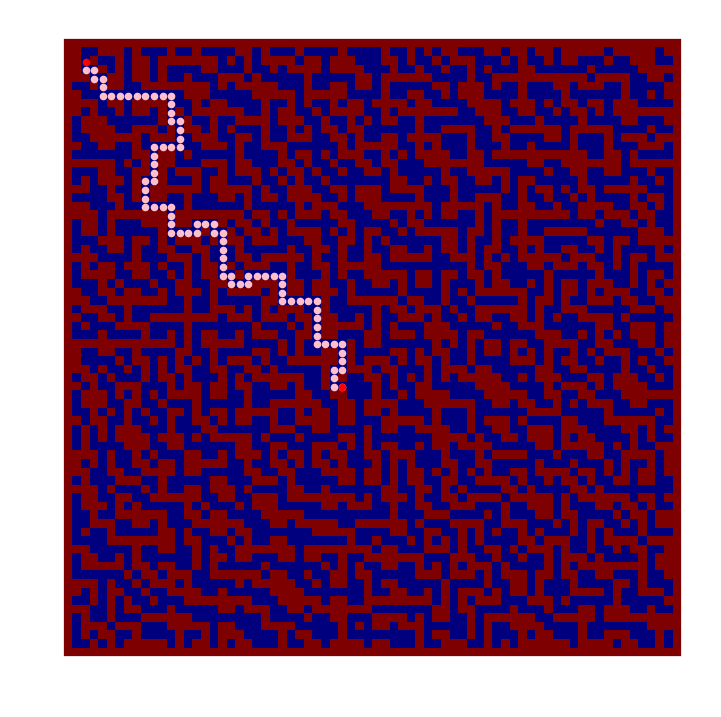

In [314]:
plt.figure(figsize=(700/80, 700/80))

node = getnode(targety, targetx)
while node != getnode(2,2):
    pos = getpos(node)
    plt.scatter((pos[1],), (pos[0],), color="pink")
    node = predecessor[getnode(2,2), node]

plt.imshow(wall, interpolation="nearest")
plt.scatter((2, 32,), (2, 40,), color="red")
plt.axis("off")
plt.show()


## Part Two

How many locations (distinct x,y coordinates, including your starting location) can you reach in at most 50 steps?

---

Since the problem size is quite small, Floyd Warshall is an easy solution. It is an all-to-all shortest distance algorithm. If we just select all nodes where the distance from the starting point is <= 50, we have our number. The algorithm scales quite badly with  `max_pos`. Setting `max_pos` to just 100 gives a noticable slowdown.

Can reach 138 distinct nodes


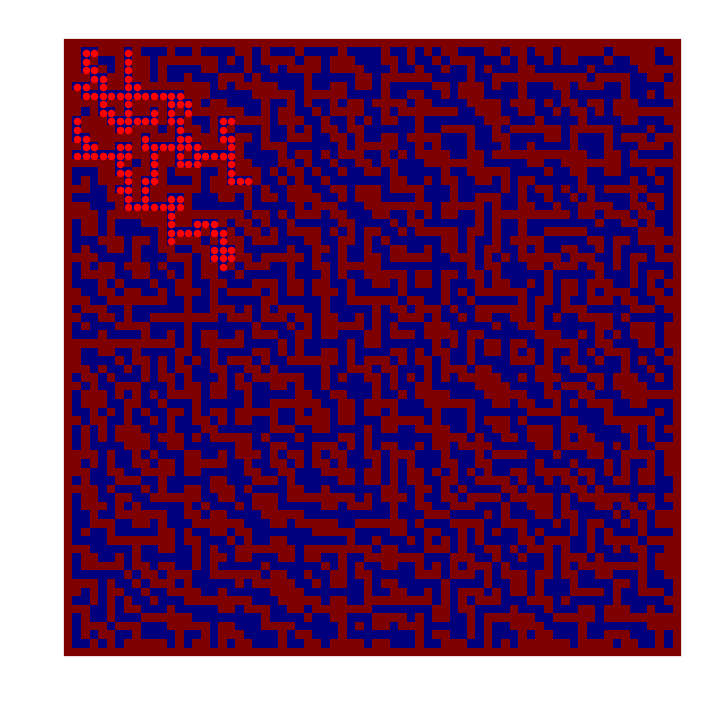

In [315]:
dist = scipy.sparse.csgraph.floyd_warshall(graph)
nodes = np.where(dist[getnode(2,2),:] <= 50)[0]
print("Can reach", len(nodes), "distinct nodes")

plt.figure(figsize=(700/80, 700/80))
plt.imshow(wall, interpolation="nearest")
for n in nodes:
    y, x = getpos(n)
    plt.scatter((x,), (y,), color="red")
plt.axis("off")
plt.show()
